# Import Libraries

In [1]:
from ipywidgets import Button, Layout, ButtonStyle, VBox, HBox, GridBox
import ipywidgets as widgets
import rospy
import os
import time
import functools
import numpy as np
from std_msgs.msg import Int32, Bool, String, Float32
from geometry_msgs.msg import Vector3
from actionlib_msgs.msg import GoalStatusArray
from move_base_msgs.msg import MoveBaseActionGoal
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation
import tf
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from tf.transformations import quaternion_matrix


In [2]:
def clbk_laser(msg): 
    """
    Callback function which is called to retrieve infos about the distances of the obstacles

    Args:
        msg(sensor_msgs/LaserScan.msg): contains ranges[] array which provides the distances each laser and the objects in the environment

    """

    global can_go_left
    global can_go_right
    global can_go_straight

    #retrieving the minimum frontal and lateral distances, if the distance is greater or equal to 1 meter, then that distance will be set to 1
    right = min(min(msg.ranges[0:143]), 0.8)
    front = min(min(msg.ranges[288:431]), 0.8)
    left = min(min(msg.ranges[576:719]), 0.8)

    #if the value is not '1', it means that it is lower and therefore the robot should not be able to go towards that direction
    if right != 0.8:
        can_go_right =False
    else:
        can_go_right =True

    if front != 0.8:
        can_go_straight =False
    else:
        can_go_straight =True

    if left != 0.8:
        can_go_left =False
    else:
        can_go_left =True


# Initialize the node and the buttons for the UI

In [3]:
rospy.init_node('jupyter')


b1 = Button(description='First Modality',layout=Layout(width='auto', align="center", grid_area='b1'),style=ButtonStyle(button_color='lightblue'))
b2 = Button(description='Second Modality',layout=Layout(width='auto', grid_area='b2'),style=ButtonStyle(button_color='moccasin'))
b3 = Button(description='Third Modality',layout=Layout(width='auto', grid_area='b3'),style=ButtonStyle(button_color='salmon'))
b4 = Button(description='Quit Modality',layout=Layout(height='auto', grid_area='b4'),style=ButtonStyle(button_color='salmon'))

ok_btn=Button(description='OK',layout=Layout(width='auto', grid_area='ok'),style=ButtonStyle(button_color='salmon'))

#Modality 2 and 3
t1 = Button(description='Left',layout=Layout(width='auto', grid_area='t1'),style=ButtonStyle(button_color='lightblue'))
t2 = Button(description='Forward',layout=Layout(width='auto', grid_area='t2'),style=ButtonStyle(button_color='moccasin'))
t3 = Button(description='Right',layout=Layout(width='auto', grid_area='t3'),style=ButtonStyle(button_color='salmon'))
t4 = Button(description='Stop Motors',layout=Layout(height='auto', grid_area='t4'),style=ButtonStyle(button_color='salmon'))
t11 = Button(description='Front-Left',layout=Layout(width='auto', grid_area='t11'),style=ButtonStyle(button_color='lightblue'))
t12 = Button(description='Front-Right',layout=Layout(width='auto', grid_area='t12'),style=ButtonStyle(button_color='moccasin'))
t13 = Button(description='Back-Left',layout=Layout(width='auto', grid_area='t13'),style=ButtonStyle(button_color='lightblue'))
t14 = Button(description='Back',layout=Layout(width='auto', grid_area='t14'),style=ButtonStyle(button_color='moccasin'))
t15 = Button(description='Back-Right',layout=Layout(width='auto', grid_area='t15'),style=ButtonStyle(button_color='lightblue'))

t5 = Button(description='Left ',layout=Layout(width='auto', align="center", grid_area='t5'),style=ButtonStyle(button_color='lightblue'))
t6 = Button(description='Forward ',layout=Layout(width='auto', grid_area='t6'),style=ButtonStyle(button_color='moccasin'))
t7 = Button(description='Right',layout=Layout(width='auto', grid_area='t7'),style=ButtonStyle(button_color='salmon'))
t8 = Button(description='Stop Motors',layout=Layout(width='auto', grid_area='t8'),style=ButtonStyle(button_color='salmon'))
t21 = Button(description='Front-Left',layout=Layout(width='auto', grid_area='t21'),style=ButtonStyle(button_color='lightblue'))
t22 = Button(description='Front-Right',layout=Layout(width='auto', grid_area='t22'),style=ButtonStyle(button_color='moccasin'))

tdecv=Button(description='Decrease Velocity ',layout=Layout(width='auto', align="center", grid_area='tdecv'),style=ButtonStyle(button_color='lightblue'))
tincv=Button(description='Increase Velocity ',layout=Layout(width='auto', align="center", grid_area='tincv'),style=ButtonStyle(button_color='lightblue'))



mb = {
        'i':(1,0,0,0),
        'o':(1,0,0,-1),
        'j':(0,0,0,1),
        'l':(0,0,0,-1),
        'u':(1,0,0,1),
        ',':(-1,0,0,0),
        '.':(-1,0,0,1),
        'm':(-1,0,0,-1),
        
    }

speed=1.0
incSpeed=1.1
decSpeed=0.9


from teleop import PublishThread
repeat = rospy.get_param("~repeat_rate", 0.0)
pub_thread = PublishThread(repeat)
pub_thread.wait_for_subscribers()
sub = rospy.Subscriber('/scan', LaserScan, clbk_laser) #subscription to /scan topic    

des_pos_x=widgets.FloatText(
    value=0.0,
    description='x coordinate:',
    disabled=False
)
des_pos_y=widgets.FloatText(
    value=0.0,
    description='y coordinate:',
    disabled=False
)

# Create publishers for changing the modality and sending goal coordinates

In [4]:
pubModality=rospy.Publisher('mode',Int32,queue_size=10) #publisher of 'mode' topic, sends user choice to other nodes
pubGoalPos=rospy.Publisher('goalpos',Vector3,queue_size=10) #publisher of 'goalpos' topic, sends the desired position
x=0.0
y=0.0
goals=[]

# Callback functions for the buttons

In [5]:
#callback function for the modality buttons, the string "rs_" should contain the integer corresponding to the modality chosen by the user
def on_button_clicked(b, rs_="some_default_string"):
    global speed
    if int(rs_)>=0 and int(rs_)<=4 and int(rs_)!=1:
        pubModality.publish(int(rs_))
    if int(rs_)==1:
        display(des_pos_x)
        display(des_pos_y)
        display(ok_btn)
    if int(rs_)==2:  
        display(cmds_mod2)
    if int(rs_)==3:  
        display(cmds_mod3)
    if int(rs_)==4:
        pub_thread.update(mb['j'][0],mb['j'][1],mb['j'][2],mb['j'][3],speed,1)
    if int(rs_)==5:
        pub_thread.update(mb['i'][0],mb['i'][1],mb['i'][2],mb['i'][3],speed,1)
    if int(rs_)==6:
        pub_thread.update(mb['l'][0],mb['l'][1],mb['l'][2],mb['l'][3],speed,1)
    if int(rs_)==12:
        pub_thread.update(mb['u'][0],mb['u'][1],mb['u'][2],mb['u'][3],speed,1)
    if int(rs_)==13:
        pub_thread.update(mb['o'][0],mb['o'][1],mb['o'][2],mb['o'][3],speed,1)
    if int(rs_)==7:
        pub_thread.update(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        
    if int(rs_)==8:
        if can_go_left:
            pub_thread.update(mb['j'][0],mb['j'][1],mb['j'][2],mb['j'][3],speed,1)
    if int(rs_)==9:
        if can_go_straight:
            pub_thread.update(mb['i'][0],mb['i'][1],mb['i'][2],mb['i'][3],speed,1)
    if int(rs_)==10:
        if can_go_right: 
            pub_thread.update(mb['l'][0],mb['l'][1],mb['l'][2],mb['l'][3],speed,1)
    if int(rs_)==11:
        pub_thread.update(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    if int(rs_)==14:
        if can_go_left and can_go_straight:
            pub_thread.update(mb['u'][0],mb['u'][1],mb['u'][2],mb['u'][3],speed,1)
    if int(rs_)==15:
        if can_go_right and can_go_straight:
            pub_thread.update(mb['o'][0],mb['o'][1],mb['o'][2],mb['o'][3],speed,1)
    if int(rs_)==18:
        if can_go_left:
            pub_thread.update(mb['m'][0],mb['m'][1],mb['m'][2],mb['m'][3],speed,1)
    if int(rs_)==19:
        if can_go_straight:
            pub_thread.update(mb[','][0],mb[','][1],mb[','][2],mb[','][3],speed,1)
    if int(rs_)==20:
        if can_go_right: 
            pub_thread.update(mb['.'][0],mb['.'][1],mb['.'][2],mb['.'][3],speed,1)
    if int(rs_)==16:
        speed=speed*incSpeed
    if int(rs_)==17:
        speed=speed*decSpeed
        
        
#Callback function for 'OK' button, it publishes the integer corresponding to the
#First Modality on '/mode' topic and the values inserted in the FloatText widgets 
#(i.e the goal position) on '/goalpos' topic.
def ok_click(b):
    #print("values are: "+str([des_pos_x.value,des_pos_y.value]))
    global x,y,goals
    x=float(des_pos_x.value)
    y=float(des_pos_y.value)
    goals.append([x,y])
    print(str(goals))
    msg=Vector3()
    msg.x=x
    msg.y=y
    pubModality.publish(1)
    pubGoalPos.publish(msg)
        
b1.on_click(functools.partial(on_button_clicked, rs_="1"))
b2.on_click(functools.partial(on_button_clicked, rs_="2"))
b3.on_click(functools.partial(on_button_clicked, rs_="3"))
b4.on_click(functools.partial(on_button_clicked, rs_="0"))

ok_btn.on_click(ok_click)

t1.on_click(functools.partial(on_button_clicked, rs_="4"))
t2.on_click(functools.partial(on_button_clicked, rs_="5"))
t3.on_click(functools.partial(on_button_clicked, rs_="6"))
t4.on_click(functools.partial(on_button_clicked, rs_="7"))
t11.on_click(functools.partial(on_button_clicked, rs_="12"))
t12.on_click(functools.partial(on_button_clicked, rs_="13"))
t13.on_click(functools.partial(on_button_clicked, rs_="18"))
t14.on_click(functools.partial(on_button_clicked, rs_="19"))
t15.on_click(functools.partial(on_button_clicked, rs_="20"))


t5.on_click(functools.partial(on_button_clicked, rs_="8"))
t6.on_click(functools.partial(on_button_clicked, rs_="9"))
t7.on_click(functools.partial(on_button_clicked, rs_="10"))
t8.on_click(functools.partial(on_button_clicked, rs_="11"))
t21.on_click(functools.partial(on_button_clicked, rs_="14"))
t22.on_click(functools.partial(on_button_clicked, rs_="15"))

tdecv.on_click(functools.partial(on_button_clicked, rs_="16"))
tincv.on_click(functools.partial(on_button_clicked, rs_="17"))
status=-1
status_=-1

# Here you can select the modality you want to run:

In [6]:
HBox([VBox([b1,b3]),VBox([b2, b4])])

GridBox(children=(Button(description='Left', layout=Layout(grid_area='t1', width='auto'), style=ButtonStyle(bu…

In [7]:
cmds_mod2=GridBox(children=[t1, t2, t3, t4,t11,t12,tdecv,tincv,t13,t14,t15],
        layout=Layout(
            width='70%',
            grid_template_rows='auto auto auto',
            grid_template_columns='20% 20% 20% 20% 20%',
            grid_template_areas='''
            "t11 t2 t2 t2 t12"
            "t1 tdecv t4 tincv t3 "
            "t13 t14 t14 t14 t15"
            ''')
       )

cmds_mod3=GridBox(children=[t5, t6, t7, t8,t21,t22,tdecv,tincv,t13,t14,t15],
        layout=Layout(
            width='70%',
            grid_template_rows='auto auto auto',
            grid_template_columns='20% 20% 20% 20% 20%',
            grid_template_areas='''
            "t21 t6 t6 t6 t22"
            "t5 tdecv t8 tincv t7 "
             "t13 t14 t14 t14 t15"
            ''')
       )

# Data Visualization

## Class for the visualization of the plots

In [8]:
%matplotlib notebook
%matplotlib notebook


class Visualiser:
    def __init__(self,x,y,goals,colors,legend_elements):
        self.x=x
        self.y=y
        self.goals=goals
        self.colors=colors
        self.legend_elements=legend_elements
        
        #Plot for the position of the robot and the requested goals init
        self.fig,self.ax = plt.subplots()
        self.ln, = self.ax.plot([], [], 'ro')
        plt.grid(True)
        self.ax.legend(handles=legend_elements) 
       
        #Polar plot init
        self.figp = plt.figure(figsize=(6,6))
        self.ax_p = plt.subplot(111, polar=True)
        self.ax_p.set_thetalim(-np.pi/2,np.pi/2)
        self.ax_p.set_theta_zero_location("N")
        self.lnp, = self.ax_p.plot([],[],'bo')
        plt.grid(True)
        

        self.laser = []
        self.x_data, self.y_data = [] , []        
        self.x_des,self.y_des=[],[]
        self.angles=[]
        self.maxMagnitude=25
    
    def plot_init(self):    
        self.ax.set_title("Position (x,y) of the Robot\n",fontweight="bold")
        self.ax.set_xlim(-7, 7)
        self.ax.set_ylim(-9,9)
        self.ax.set_xlabel("X Coordinate [m]",fontweight="bold")
        self.ax.set_ylabel("Y Coordinate [m]",fontweight="bold")
         
        self.ax_p.set_title("Distance of the Obstacles",fontweight="bold")
        self.ax_p.set_xlabel("Orientation [deg]",fontweight="bold")
        self.ax_p.set_ylabel("Distance [m]",fontweight="bold")
        
        return self.ln
    
    #Callback for /scan topic, in this case we want to visualize data in terms of polar coordinates, i.e. 'rho' and 'theta'
    def clbk_scan(self, msg):
        self.laser=list(msg.ranges) 
        self.angles = list(np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment))
        return self.laser
    
    #Callback for /odom topic, it retrieves the current position of the robot  
    def clbk_odom(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
    
    #Callback for /move_base/status topic, it retrieves the status of the goal and eventually changes the color of the goal
    def clbk_status(self,msg):

        global status,status_

        if msg.status_list != []:    #if the list is empty it means that no goal has been processed yet
            status = msg.status_list[0].status   #retrieve the status of the goal
        
        if status!=status_: #to check if the status has changed
            if status==2:
                self.colors[-1]='r' #set the color of the point to red
                
            elif status==3:
                self.colors[-1]='g' #set the color of the point to green
               
        
        #print("status: "+str(self.status))
        #print("status_: "+str(self.status_))
        status_=status
    
    #Callback for /move_base/goal topic, it is called whenever a new action is required
    def clbk_goal(self,msg):
        self.x_des.append(x) #adds the point to the list that will be given as argument to the scatter plot
        self.y_des.append(y) 
        self.colors.append('y') #the color of the goal is initially set to yellow (i.e. 'pending')
 
    #Update function for the graphic regarding the position of the robot and the requested goals
    def update_plot_pos_goal(self, frame): 
        self.legend_elements[0].set_label('Not Achieved: '+str(self.colors.count("r"))) #the legend takes into account the number of reached/not reached goals
        self.legend_elements[2].set_label('Achieved: '+str(self.colors.count("g")))
        self.ax.legend(handles=self.legend_elements)
        self.ax.scatter(self.x_des,self.y_des,c=self.colors) #updating scatter plot for requested goals
        for i, txt in enumerate(self.goals): #annotates the coordinate near the point in the scatter plot
            self.ax.annotate(self.goals[i], (self.x_des[i], self.y_des[i]))
        self.ln.set_data(self.x_data, self.y_data) #updating the robot position      
        return self.ln
    
    #Update function for the polar plot
    def update_polar(self, frame):   
        self.ax_p.set_rmax(self.maxMagnitude)
        self.lnp.set_data(self.angles,self.laser)
        return self.lnp
                        

        

## Subscription to the topics needed for the visualization

<IPython.core.display.Javascript object>


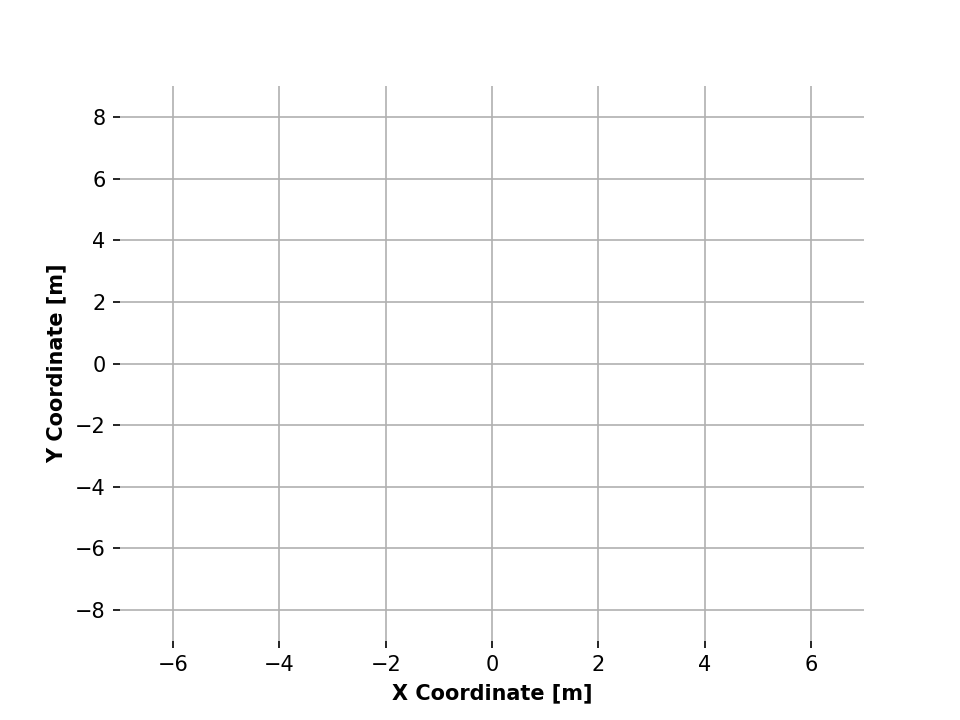

<IPython.core.display.Javascript object>


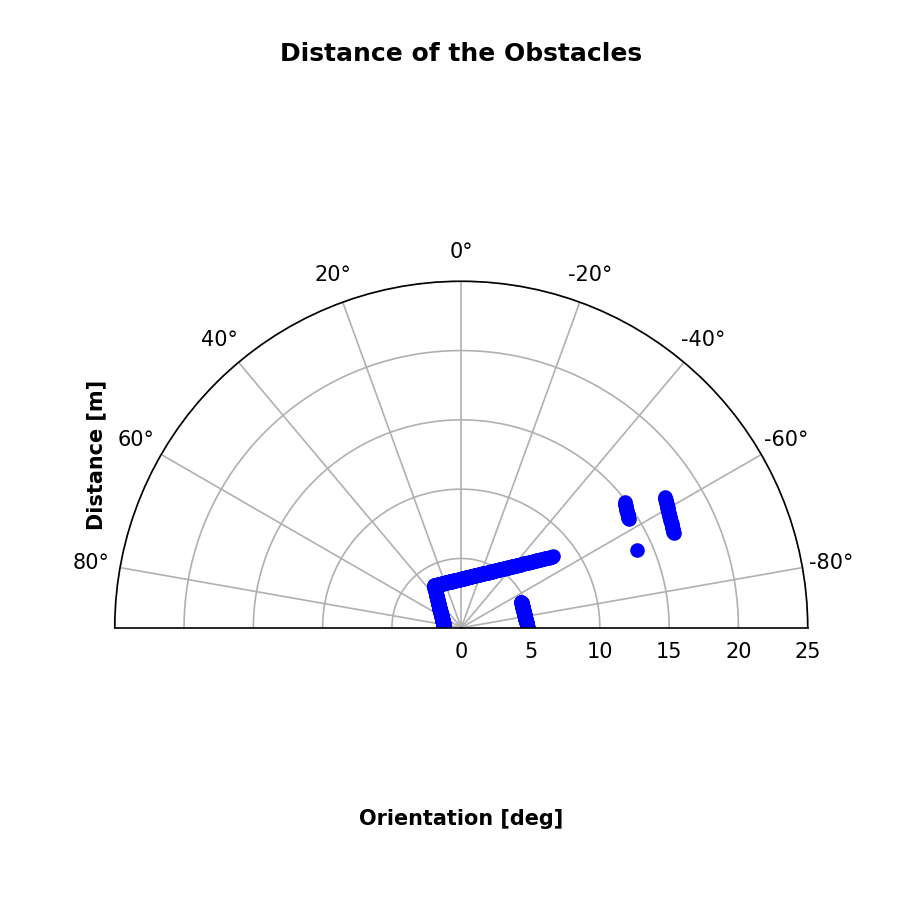

In [9]:
colors=[]
x_fromAni=[]
y_fromAni=[]
legend_elements = [Line2D([0], [0],marker='o', color='w', label='Not Achieved: 0',
                          markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Pending',
                          markerfacecolor='y', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Achieved: 0',
                          markerfacecolor='g', markersize=10)]

vis = Visualiser(x,y,goals,colors,legend_elements) #instance of Visualiser class
subOdom = rospy.Subscriber('/odom', Odometry, vis.clbk_odom) #subscription to '/odom' topic
subScan = rospy.Subscriber('/scan', LaserScan, vis.clbk_scan) #subscription to '/scan' topic
subStatus=rospy.Subscriber('/move_base/status',GoalStatusArray,vis.clbk_status) #subscription to '/move_base/status' topic
subGoal=rospy.Subscriber('/move_base/goal',MoveBaseActionGoal,vis.clbk_goal) #subscription to '/move_base/goal' topic

## Instance FuncAnimation objects

In [10]:
PositionGoalAnim = FuncAnimation(vis.fig, vis.update_plot_pos_goal, init_func=vis.plot_init) #FuncAnimation for the first plot
PolarPlotAnim= FuncAnimation(vis.figp, vis.update_polar, blit = True) #FuncAnimation for the second plot
plt.show(block=True)